# Quantitative Spatial Economics 

## Tutorial Topic 2: Monocentric City Model

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](dominik.bursy@icloud.com), 
[Lars Felder](lars.felder@fu-berlin.de), 
[Kate Bablyak](kateryna.bablyak@student.hu-berlin.de), 
[Marlon Krippendorf](marlon.krippendorf@fu-berlin.de)


Last Update: May 2024

---

In Topic 2,we covered the monocentric city model in the lecture. In this tutorial, we test for the central prediction of the model, i.e. that bid-rents fall in distance from the central business district.

---

## Directory Structure

Start by cloning the repository [AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/) in the ressource directory and copy `_USE_PREDICT.do` to the notebooks directory. lfelder: Note that you need to rename the repo to `AHS2023-toolkit-main` as this is the folder name used in the `_USE_PREDICT.do` file.

```bash
├── data
│   ├── _README.txt
│   ├── county-employment-2023
│   ├── county-gdp_capita-2021
│   ├── county-wages-2022
│   ├── RWI-GEO-RED-2022
│   └── Shapefiles-2022
├── experiments
├── notebooks
│   ├── _USE_PREDICT.do
│   ├── QSE_Tutorial_1_Group_2.ipynb
│   └── QSE_Tutorial_2_Group_2.ipynb
├── output
├── resources
│   ├── AHS2023-toolkit-main
│   └── Tutorial_Handout_2.pdf
├── requirements.txt
├── README.md
└── LICENSE
```

## Table of Contents

- [Import Packages](#packages)
- [Data Import and Data Preparation](#data_import)
    - [Data Import 1: German Cities](#data_import_1)
    - [Data Import 2: Transactions Panel](#data_import_2)
    - [Data Preparation](#data_preparation)
- [Task 1: Create House Price Index](#price_index)
- [Task 2: Vizualize House Price Index](#vizualization)
- [Task 3: Price Gradient from Central Business Districts (CBD)](#price_gradient)
- [Task 4: Conclusion](#conclusion)
- [Appendix](#appendix)
- [References](#references)

## Import Packages <a class="anchor" id="packages"></a>

In [53]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [54]:
## Define user: (Necessary for using the correct stata install on machine, add your handle and extend if else condition when first loading stata)
user_lfelder = 0

In [55]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## Data Import and Data Preparation <a class="anchor" id="data_import"></a>

In [56]:
## Create Output Directory
OUTPUT_FOLDER = f'{ROOT_FOLDER}/data/ahs_index'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# os.rmdir(OUTPUT_FOLDER)

### Data Import 1: German Cities <a class="anchor" id="data_import_1"></a>

In [57]:
## Load shapefile of German postal codes 
gdf_zip_codes = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/POSTCODES/postcode_clean_final.shp')

In [58]:
gdf_zip_codes.head()

,OBJECTID,ZIP_CODE,ZIP,postcodeid,pcode_id,Shape_Leng,Shape_Area,INSIDE_X,INSIDE_Y,geometry
0,1,01067,1067,1067,1067,11890.745390,6.720631e+06,830654.428259,5.666966e+06,"POLYGON ((831410.495 5667515.945, 831559.316 5..."
1,2,01069,1069,1069,1069,13214.193144,5.329498e+06,832049.898982,5.664771e+06,"POLYGON ((832798.807 5666507.614, 832968.037 5..."
2,3,01097,1097,1097,1097,8845.169181,3.422312e+06,832209.594152,5.667815e+06,"POLYGON ((831750.103 5668789.004, 831962.249 5..."
3,4,01099,1099,1099,1099,35957.696431,5.288933e+07,837971.403188,5.671078e+06,"POLYGON ((843279.373 5672057.918, 843390.193 5..."
4,5,01108,1108,1108,1108,24218.518005,1.629541e+07,834591.563039,5.677793e+06,"POLYGON ((832701.093 5679958.057, 833001.909 5..."


In [59]:
## Load data on German cities on postal code level 
url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/csv?lang=en&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B'
df_cities = pd.read_csv(url, delimiter=';')

## Alternatively, load georeferenced German cities on postal code level 
# url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/shp?lang=en&timezone=Europe%2FBerlin'
# df_cities = gpd.read_file(url)

In [60]:
df_cities.head()

,Name,PLZ Name (short),PLZ Name (long),Geometry,Postleitzahl / Post code,Kreis code,Land name,Land code,Kreis name,geo_point_2d
0,52134,Herzogenrath,52134 Herzogenrath,"{""coordinates"": [[[6.057427, 50.8510367], [6.0...",52134,5334,Nordrhein-Westfalen,5,Kreis Städteregion Aachen,"50.8638900847, 6.09832161494"
1,41372,Niederkrüchten,41372 Niederkrüchten,"{""coordinates"": [[[6.0679863, 51.2205478], [6....",41372,5166,Nordrhein-Westfalen,5,Kreis Viersen,"51.2048375784, 6.15424337541"
2,52379,Langerwehe,52379 Langerwehe,"{""coordinates"": [[[6.298514, 50.7923355], [6.2...",52379,5358,Nordrhein-Westfalen,5,Kreis Düren,"50.7987741433, 6.3643683641"
3,54614,Schönecken,54614 Schönecken,"{""coordinates"": [[[6.4028411, 50.142931], [6.4...",54614,7232,Rheinland-Pfalz,7,Landkreis Eifelkreis Bitburg-Prüm,"50.1510017758, 6.44878094816"
4,53949,Dahlem,53949 Dahlem,"{""coordinates"": [[[6.4130222, 50.3894505], [6....",53949,5366,Nordrhein-Westfalen,5,Kreis Euskirchen,"50.3959654257, 6.51099135402"


In [61]:
## Subset to largest German cities: Berlin, Hamburg, Munich, Cologne, Frankfurt
condition_berlin = (df_cities['Kreis name'] == 'Kreisfreie Stadt Berlin')
condition_hamburg = (df_cities['Kreis name'] == 'Kreisfreie Stadt Hamburg')
condition_munich = (df_cities['PLZ Name (short)'] == 'München') ## Excludes Haar
condition_cologne = (df_cities['PLZ Name (short)'] == 'Köln') ## Excludes Gladbach
condition_frankfurt = (df_cities['Kreis name'] == 'Kreisfreie Stadt Frankfurt am Main')
# condition_frankfurt = ((df_cities['Kreis name'] == 'Kreisfreie Stadt München').astype(int) - (df_cities['PLZ Name (short)'] == 'München').astype(int)) == 1
condition_cities = [condition_berlin, condition_hamburg, condition_munich, condition_cologne, condition_frankfurt]

## Encode cities and create indicators
cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
for index, city in enumerate(cities):
    df_cities.loc[condition_cities[index], city] = 1
    df_cities.loc[condition_cities[index], 'city'] = city
df_cities[cities] = df_cities[cities].fillna(value=0)

## Rename columns
df_cities.rename(columns={'Name':'plz'}, inplace=True)

## Drop duplicates
df_cities.drop_duplicates(subset=['plz', 'city'], inplace=True)

In [62]:
## Add city information to postal code shapefile 
gdf_zip_codes = gdf_zip_codes.set_index('ZIP').join(
    df_cities[cities + ['city', 'plz']].set_index('plz'), validate='1:m').dropna(subset=['city']).reset_index()

In [63]:
## Calculate the geographic center of each postalcode
#gdf_zip_codes['shape_center_x'] = gdf_zip_codes.centroid.x
#gdf_zip_codes['shape_center_y'] = gdf_zip_codes.centroid.y

## Rename columns and subset dataframe
# gdf_zip_codes.rename(columns={'index':'target_id', 'INSIDE_X':'target_x', 'INSIDE_Y': 'target_y',
#                              'OBJECTID': 'shape_id', 'Shape_Leng':'shape_length', 'Shape_Area':'shape_area', 
#                              }, inplace=True)
# gdf_zip_codes = gdf_zip_codes[['target_id', 'target_x', 'target_y', 'shape_id', 'shape_length', 'shape_area', #'shape_center_x', 'shape_center_y', 
#                                'city', 'berlin', 'hamburg', 'munich', 'cologne', 'frankfurt', 'geometry']]


## lfelder: Inexperienced, but this yields error cause "index" is not a column and pandas will not rename it, therefore target_id is never created.
# If I understand correctly ZIP is our index, which is now a regular column due to the .reset_index() in the cell above
gdf_zip_codes.rename(columns={'ZIP_CODE':'target_id', 'INSIDE_X':'target_x', 'INSIDE_Y': 'target_y',
                             'OBJECTID': 'shape_id', 'Shape_Leng':'shape_length', 'Shape_Area':'shape_area', 
                             }, inplace=True)
gdf_zip_codes = gdf_zip_codes[['target_id', 'target_x', 'target_y', 'shape_id', 'shape_length', 'shape_area', #'shape_center_x', 'shape_center_y', 
                               'city', 'berlin', 'hamburg', 'munich', 'cologne', 'frankfurt', 'geometry']]
gdf_zip_codes['target_id'] = gdf_zip_codes['target_id'].astype(int)


In [64]:
## Export dataframe
gdf_zip_codes.drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 
# gdf_zip_codes.loc[gdf_zip_codes['city'] == 'berlin'].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 

### Data Import 2: Transactions Panel <a class="anchor" id="data_import_2"></a>

In [65]:
## Load dataframes on housing market transcations
df_hk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_HK_cities.dta')
df_wk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WK_cities.dta')
df_wm = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WM_cities.dta')

In [66]:
## Define transaction type: Kaufen vs Mieten
df_hk['type'] = 0
df_wk['type'] = 0
df_wm['type'] = 1

## Concatinate dataframes 
df_transactions = pd.concat([df_hk, df_wk, df_wm], axis=0)

## Drop duplicates
df_transactions.drop_duplicates(inplace=True)

## Drop missing postal codes
df_transactions = df_transactions.loc[pd.to_numeric(df_transactions['plz'], errors='coerce').notna()]
df_transactions['plz'] = df_transactions['plz'].astype(int)

In [67]:
## Merge with cities 
gdf_transactions = gdf_zip_codes.set_index('target_id').join(df_transactions.set_index('plz'), validate='1:m')

## Add x-y coordinate (in ETRS) projections
df_georeference = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/_grid_georeferences/grid.coordinaten_xy.dta')
gdf_transactions = gdf_transactions.set_index('ergg_1km').join(df_georeference.set_index('ergg_1km'), validate='m:1').reset_index()

## Drop missing values
gdf_transactions.dropna(subset=['origin_X', 'origin_Y'], inplace=True)

### Data Preparation <a class="anchor" id="data_preparation"></a>

In [68]:
## lprice_qm and year
gdf_transactions.loc[gdf_transactions['type'] == 0, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 0, 'price_sqm'])
gdf_transactions.loc[gdf_transactions['type'] == 1, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 1, 'rent_sqm'])
gdf_transactions['year'] = gdf_transactions['edat'].dt.year

## Hedonic characteristics
gdf_transactions['age'] = 2022 - gdf_transactions['baujahr']
gdf_transactions.loc[gdf_transactions['etage'] == 'Other missing', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['etage'] == 'Implausible value', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan

## Demeaning of hedonic characteristics
for var in ['age', 'etage', 'zimmeranzahl', 'wohnflaeche']:
    #mean_val = gdf_transactions[var].mean()
    gdf_transactions[f'Att_{var}'] = gdf_transactions[var] #- mean_val
gdf_transactions['city'] = gdf_transactions['city'].astype('category')
gdf_transactions['Att_etage'] = gdf_transactions['Att_etage'].astype(float)
gdf_transactions['Att_zimmeranzahl'] = gdf_transactions['Att_zimmeranzahl'].astype(float)

In [69]:
## Rename columns and subset dataframe and drop duplicates
gdf_transactions.rename(columns={'obid':'transactions_id', 'city':'submarketid'}, inplace=True)
gdf_transactions = gdf_transactions[[
    'transactions_id', 'lprice_qm', 'year', 'Att_age', 'Att_etage', 'Att_zimmeranzahl', 'Att_wohnflaeche', 'submarketid', 'origin_X', 'origin_Y', 'type', 'geometry'
]].drop_duplicates()

In [70]:
## Export dataframe
gdf_transactions.loc[gdf_transactions['type'] == 0].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_purchase.dta') 
gdf_transactions.loc[gdf_transactions['type'] == 1].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_rent.dta') 

In [ ]:
## Export dataframe
# gdf_transactions.loc[(gdf_transactions['type'] == 0) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_purchase.dta') 
# gdf_transactions.loc[(gdf_transactions['type'] == 1) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_rent.dta') 

---

## Task 1: Create House Price Index <a class="anchor" id="price_index"></a>

In [20]:
# Setup Stata
if user_lfelder == 1:
    import stata_setup
    stata_setup.config("C:\\Program Files\\Stata18", "mp", splash=True)
else: 
    import stata_setup
    stata_setup.config("/Applications/Stata", "se", splash=True)


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      StataNow 18.5
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: Unlimited-user 32-core network, expiring 19 Aug 2025
Serial number: 501809307294
  Licensed to: DIW Berlin
               DIW Berlin

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [21]:
%%stata
cd ..
pwd


. cd ..
c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration

. pwd
c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration

. 


In [22]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_purchase.dta"
do "notebooks/_USE_PREDICT.do"
save "data/ahs_index/AHS_Index_purchase.dta", replace


. use "data/ahs_index/centroids.dta", clear



. global transaction_dataset "data/ahs_index/transactions_purchase.dta"

. do "notebooks/_USE_PREDICT.do"

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q

. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***
. 
. // This program loads estimates a property price index for arbitrary coordina
> tes
. // in the target data set usi

In [23]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_rent.dta"
do "notebooks/_USE_PREDICT.do" 
save "data/ahs_index/AHS_Index_rent.dta", replace


. use "data/ahs_index/centroids.dta", clear

. global transaction_dataset "data/ahs_index/transactions_rent.dta"

. do "notebooks/_USE_PREDICT.do" 

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q

. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***
. 
. // This program loads estimates a property price index for arbitrary coor

In [24]:
## Remove temporary files
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.csv')
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.dta')

---

## Task 2: Vizualize House Price Index<a class="anchor" id="vizualization"></a>

In [127]:
gdf_purchase_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_purchase.dta').set_index('shape_id'))
gdf_rent_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_rent.dta').set_index('shape_id'))

In [128]:
# Calculate log difference (approximates the percent change for small changes)
gdf_purchase_index['dlprice_qm'] = np.log(gdf_purchase_index['price_qm2022']) - np.log(gdf_purchase_index['price_qm2007'])
gdf_rent_index['dlprice_qm'] = np.log(gdf_rent_index['price_qm2022']) - np.log(gdf_rent_index['price_qm2007'])

# Convert log difference to growth factor
gdf_purchase_index['growth_factor'] = np.exp(gdf_purchase_index['dlprice_qm'])
gdf_rent_index['growth_factor'] = np.exp(gdf_rent_index['dlprice_qm'])

# Convert growth factor to percentage change --- Better in our case, as prices have changed quite dramatically.
gdf_purchase_index['percentage_change'] = (gdf_purchase_index['growth_factor'] - 1) * 100
gdf_rent_index['percentage_change'] = (gdf_rent_index['growth_factor'] - 1) * 100

In [129]:
## Shapefile Stadtbezirke Berlin
# https://daten.odis-berlin.de/de/dataset/bezirksgrenzen/
gdf_berlin = gpd.read_file('https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson')
gdf_berlin.to_crs('25832', inplace=True)

## Shapefile Stadtbezirke Munich
# https://opendata.muenchen.de/dataset?res_format=WMS
# gdf_munich = gpd.read_file('https://geoportal.muenchen.de/geoserver/gsm_wfs/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=gsm_wfs:vablock_stadtbezirke_opendata&outputFormat=application/json')

### Real Estate Prices

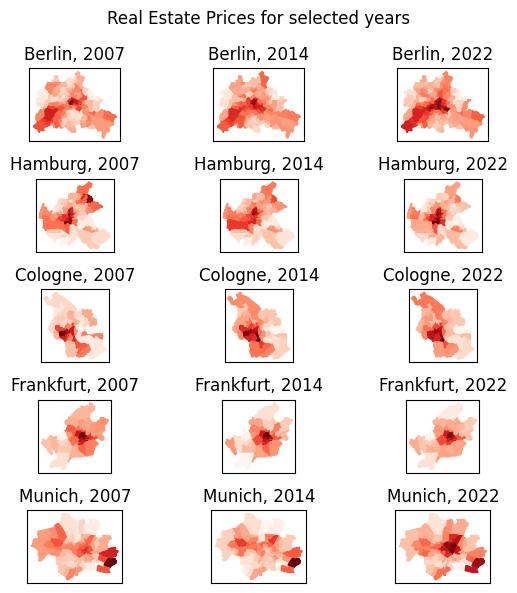

In [130]:
# All cities purchases, but only selected years 

figure, axis = plt.subplots(5, 3, figsize=(6, 6)) 

axis = axis.flatten()
cities = gdf_rent_index['city'].unique()
display_years = [2007,2014,2022]

index = 0
for city in cities:
    for year in display_years:
        gdf_purchase_index.loc[gdf_rent_index['city'] == city].plot(
            column='price_qm' + str(year),
            cmap='Reds',
            edgecolor='face',
            ax=axis[index]
        )
        axis[index].set_xticks([])
        axis[index].set_yticks([])
        axis[index].set_title(f'{city.title()}, {year}')
        index += 1
figure.suptitle('Real Estate Prices for selected years')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_purchase_all_cities.png', bbox_inches='tight')
else:
    plt.tight_layout()

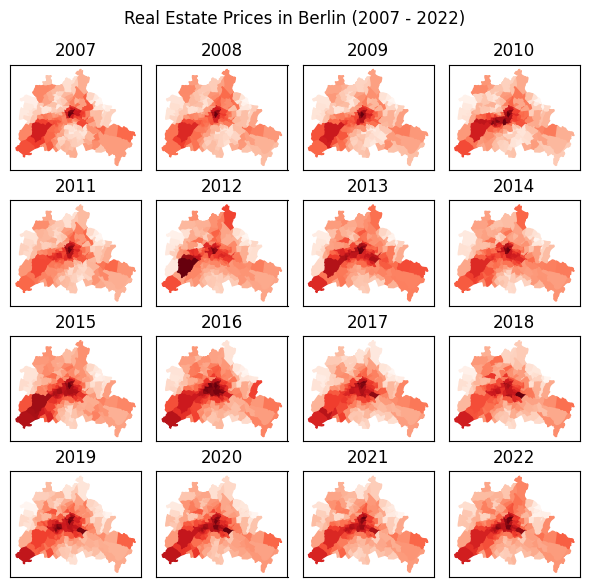

In [131]:
# Berlin  - purchases, but all years
figure, axis = plt.subplots(4, 4, figsize=(6, 6)) 
axis = axis.flatten()

for index, year in enumerate(range(2007, 2023)):
    gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index])
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{year}')
figure.suptitle('Real Estate Prices in Berlin (2007 - 2022)')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

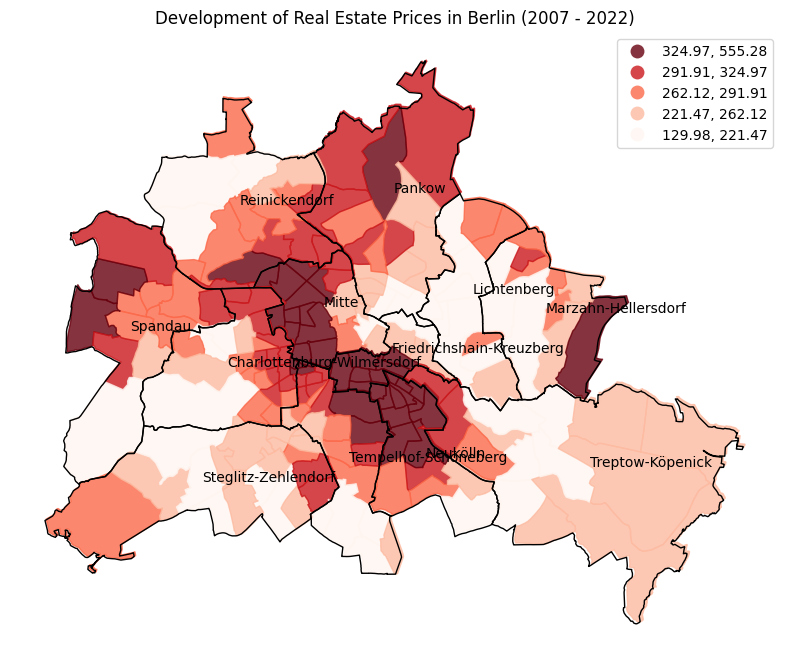

In [134]:
# This plots the percent change of purchase prices

figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='percentage_change', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_purchase_berlin_percent.png', bbox_inches='tight')
else:
    plt.tight_layout()

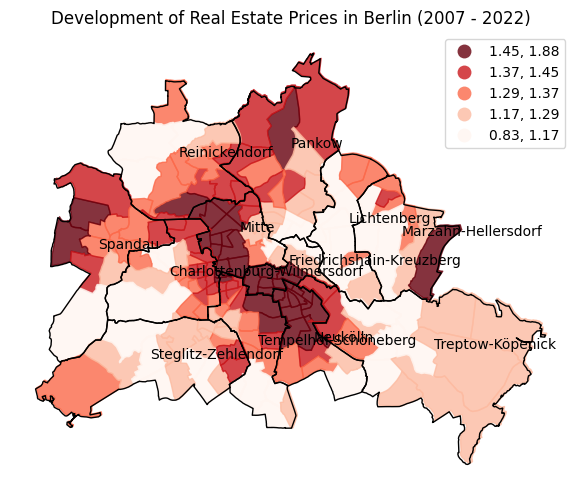

In [ ]:
# This plots the log difference  of purchase prices, same qualitative result, but not a good approximation of percentage change

figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

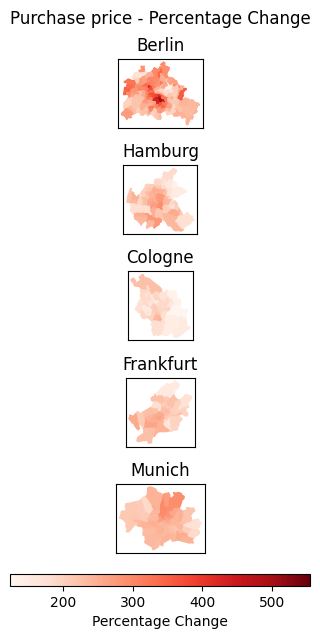

In [136]:
# Plot purchase price percentage change for all cities --- not suuuper helpfull because of Berlin outlier, but interesting result in and of itself

figure, axis = plt.subplots(5, 1, figsize=(6, 6))
axis = axis.flatten()
cities = gdf_rent_index['city'].unique()

# Define common colormap normalization across all plots - important so that coloring is comparable across cities
vmin = gdf_purchase_index['percentage_change'].min()
vmax = gdf_purchase_index['percentage_change'].max()
cmap = 'Reds'
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for index, city in enumerate(cities):
    gdf_purchase_index.loc[gdf_purchase_index['city'] == city].plot(
        column='percentage_change',
        cmap=cmap,
        edgecolor='face',
        ax=axis[index],
        norm=norm
    )
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{city.title()}')

plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # leave space for the colorbar and title

# Add a new axes for the colorbar underneath the plots
cbar_ax = figure.add_axes([0.25, 0.02, 0.5, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = figure.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage Change')

figure.suptitle(f'Purchase price - Percentage Change')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_purchase_all_cities_perc_change.png', bbox_inches='tight')
else:
    plt.show()


---

### Rent Prices

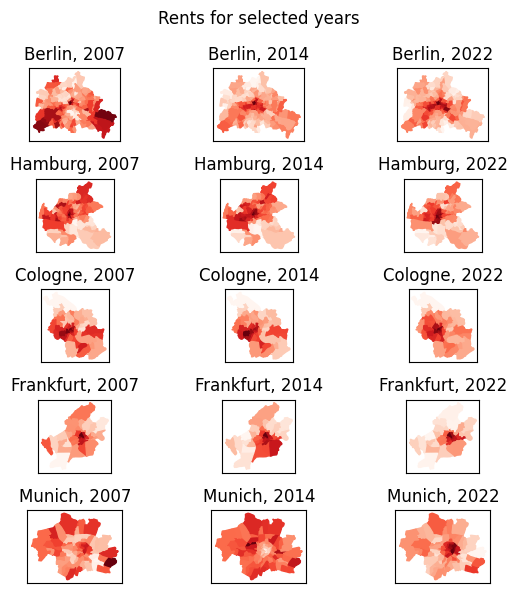

In [137]:
# All cities rents, but only selected years 

figure, axis = plt.subplots(5, 3, figsize=(6, 6)) 

axis = axis.flatten()
cities = gdf_rent_index['city'].unique()
display_years = [2007,2014,2022]

index = 0
for city in cities:
    for year in display_years:
        gdf_rent_index.loc[gdf_rent_index['city'] == city].plot(
            column='price_qm' + str(year),
            cmap='Reds',
            edgecolor='face',
            ax=axis[index]
        )
        axis[index].set_xticks([])
        axis[index].set_yticks([])
        axis[index].set_title(f'{city.title()}, {year}')
        index += 1
figure.suptitle('Rents for selected years')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_purchase_all_cities.png', bbox_inches='tight')
else:
    plt.tight_layout()

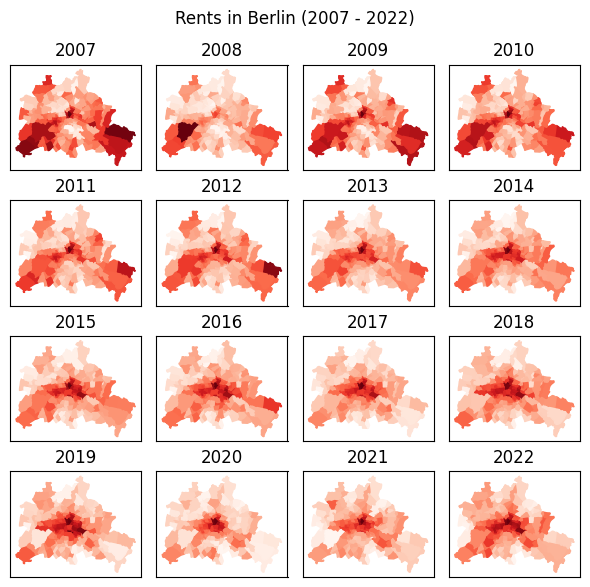

In [138]:
# Berlin  - rents, but all years

figure, axis = plt.subplots(4, 4, figsize=(6, 6)) 
axis = axis.flatten()

for index, year in enumerate(range(2007, 2023)):
    gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index])
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{year}')
figure.suptitle('Rents in Berlin (2007 - 2022)')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/rents_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

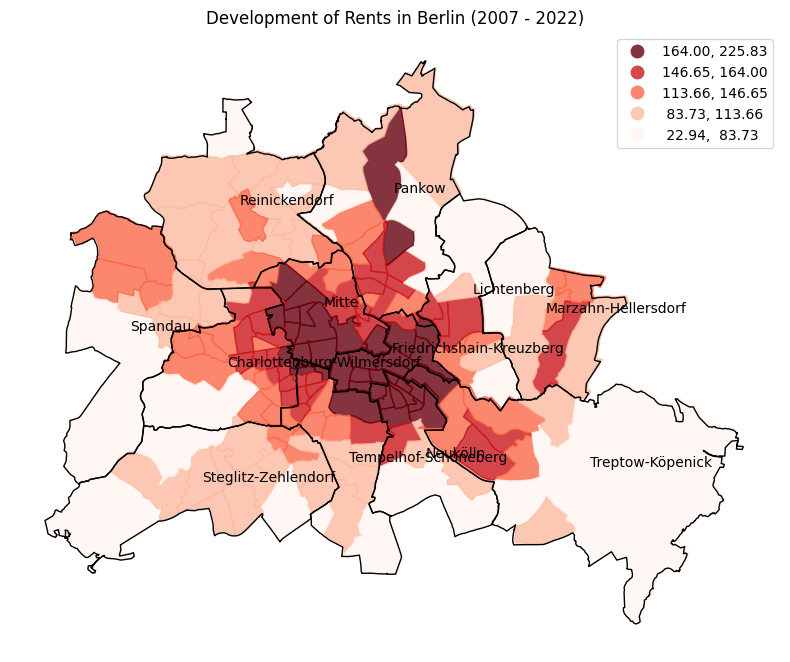

In [139]:
# This plots the percent change of rents
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='percentage_change', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Rents in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_rents_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

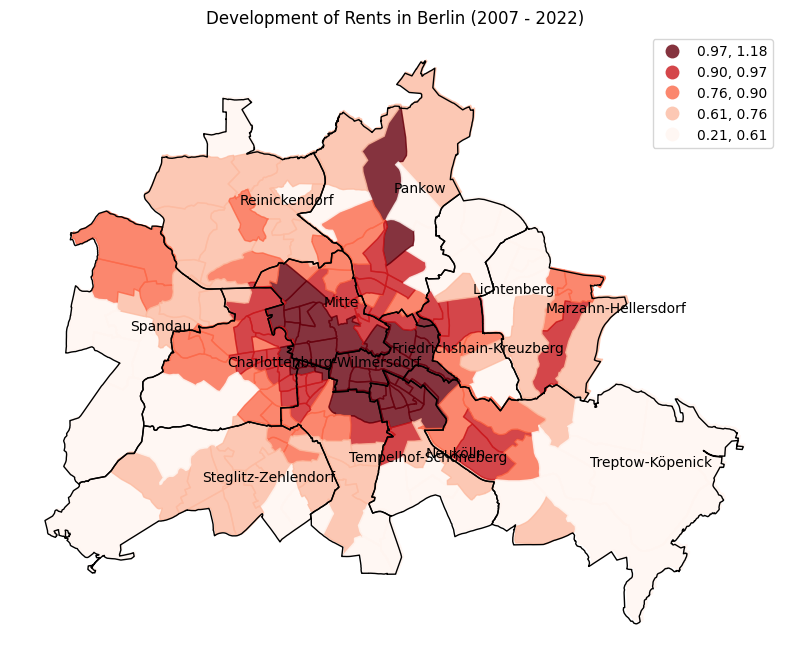

In [140]:
# This plots the log difference  of rents, same qualitative result, but not a good approximation of percentage change
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Rents in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_rents_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

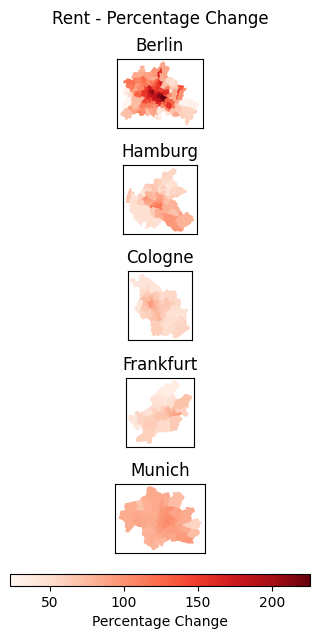

In [142]:
# Plot rent percentage change for all cities --- not suuuper helpfull because of Berlin outlier, but interesting result in and of itself

figure, axis = plt.subplots(5, 1, figsize=(6, 6))
axis = axis.flatten()
cities = gdf_rent_index['city'].unique()

# Define common colormap normalization across all plots - so that cities are comparable
vmin = gdf_rent_index['percentage_change'].min()
vmax = gdf_rent_index['percentage_change'].max()
cmap = 'Reds'
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for index, city in enumerate(cities):
    gdf_rent_index.loc[gdf_rent_index['city'] == city].plot(
        column='percentage_change',
        cmap=cmap,
        edgecolor='face',
        ax=axis[index],
        norm=norm
    )
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{city.title()}')

plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # leave space for the colorbar and title

# Add a new axes for the colorbar underneath the plots
cbar_ax = figure.add_axes([0.25, 0.02, 0.5, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = figure.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percentage Change')

figure.suptitle(f'Rent - Percentage Change')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_rent_all_cities_perc_change.png', bbox_inches='tight')
else:
    plt.show()


---

### Interpreation

Does the pattern conform to the monocentric city model?

- The Monocentric City Model would predict High Rents and High Purchase Prices in Central Business Districts (CBD).
- However, in the data for Berlin, we tend to find two areas where prices are high: in the city center and in the area closer to Potsdam.
- This points to one shortcoming of the Monocentric City Model, which ignores factors other than the proximity of workers’ housing location to  their central workplace.
- High prices in areas closer to Potsdam are probably driven by their proximity to another major German city, nature, etc.
- Suggestion: instead of analyzing cities as labour markets, take a broader stance and analyze local labour markets, to which people from multiple cities commute

Are there any obvious changes over time?

- In Berlin, the city center expands over time
- In Hamburg, we see the opposite trend: the city center concentrates
- In Cologne, areas to the west of the Rhine river are much more expensive than areas to the east
- In Frankfurt, we don’t observe much change in city center dispersion over time
- In Munich, prices increase in general, but the spatial pattern does not change much

---

## Task 3: Price Gradient from Central Business Districts (CBD) <a class="anchor" id="price_gradient"></a>

In [93]:
## Berlin CBD: 10117
## Munich CBD: 80331
# gdf_rent_index.loc[gdf_rent_index['city'] == 'hamburg'].interests(gpd.read_file('/Users/dominik.bursy/Downloads/shape_43/PL_43.shp').to_crs(gdf_rent_index.loc[gdf_rent_index['city'] == 'hamburg'].crs))

In [95]:
## The CBD is the place in the city that congregates the largest share of employment. 
# Define CBD codes per city
cbd_mapping = {
    'berlin': 10117,
    'hamburg': 20148,
    'munich': 80331,
    'cologne': 50667, # City Council
    'frankfurt': 60313
}

def assign_cbd_flag(gdf):
    gdf['cbd'] = 0
    for city, cbd_zip in cbd_mapping.items():
        condition = (gdf['city'] == city) & (gdf['target_id'] == cbd_zip)
        gdf.loc[condition, 'cbd'] = 1
    return gdf

# Apply to both datasets
gdf_purchase_index = assign_cbd_flag(gdf_purchase_index)
gdf_rent_index = assign_cbd_flag(gdf_rent_index)

In [96]:
## Transform prices to log prices 
for year in range(2007, 2023):
    gdf_purchase_index['lprice_qm'+str(year)] = np.log(gdf_purchase_index['price_qm'+str(year)])
    gdf_rent_index['lprice_qm'+str(year)] = np.log(gdf_rent_index['price_qm'+str(year)])

Note that the distance measure is the euclidian distance of two ETRS projected coordinates i.e. it is measured in meters. For inerpretation purposes of the regression coefficients it might make sense to multiply by 100 for 100meters as 1meter is a too small change to be of practical relevance. 

In [97]:
# Define the function to compute euclidian distance using R2 norm distances
def calculate_distance(gdf):
    cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
    
    for city in cities:
        condition_cbd = (gdf['city'] == city) & (gdf['cbd'] == 1)
        condition_cbd_not = (gdf['city'] == city)

        # Distance will be zero for cbd
        gdf.loc[gdf['city'] == city, 'distance'] = np.sqrt(
            (gdf.loc[condition_cbd_not, 'target_x'] - gdf.loc[condition_cbd, 'target_x'].values)**2 +
            (gdf.loc[condition_cbd_not, 'target_y'] - gdf.loc[condition_cbd, 'target_y'].values)**2
        )
    
    return gdf

gdf_purchase_index = calculate_distance(gdf_purchase_index)
gdf_rent_index = calculate_distance(gdf_rent_index)

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'].describe()


count      190.000000
mean      8576.110086
std       4520.706628
min          0.000000
25%       4923.990713
50%       7685.394276
75%      11771.432472
max      23086.288934
Name: distance, dtype: float64

In [ ]:
import statsmodels.api as sm

cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
results_dict = {}

for city in cities:
    df_city = gdf_purchase_index[gdf_purchase_index['city'] == city]
    df_city = df_city[['lprice_qm2007', 'distance']].dropna()
    Y = df_city['lprice_qm2007']
    X = sm.add_constant(df_city['distance'])  # Add constant term

    model = sm.OLS(Y, X)
    results = model.fit()

    # Scale the coefficients by 1000, interpretation of coefficient now: 1km more distance
    scaled_params = results.params * 1000
    results_dict[city] = scaled_params

# Compare distance coefficient across cities, a bit hard to read currently bc. of the scaling of the distance measure
print("Distance Coefficients (sclaed by 1000) by City in 2007:")
for city in cities:
    coef = results_dict[city]['distance']
    print(f"{city.title():<10}: {coef:.10f}")    


Distance Coefficients (sclaed by 1000) by City in 2007:
Berlin    : -0.0204865874
Hamburg   : -0.0252524629
Munich    : -0.0097987741
Cologne   : -0.0324136596
Frankfurt : -0.0682054967


Interpretation of the coefficients above: 
In 2007: an increase in distance from cbd by 1km in Berlin is associated with a decrease in purchase prices by 2%. This effect is larger for all other cities with the weird exception of Munich (where everything is expensive everywhere, bc. ppl. work in automotive industry?)

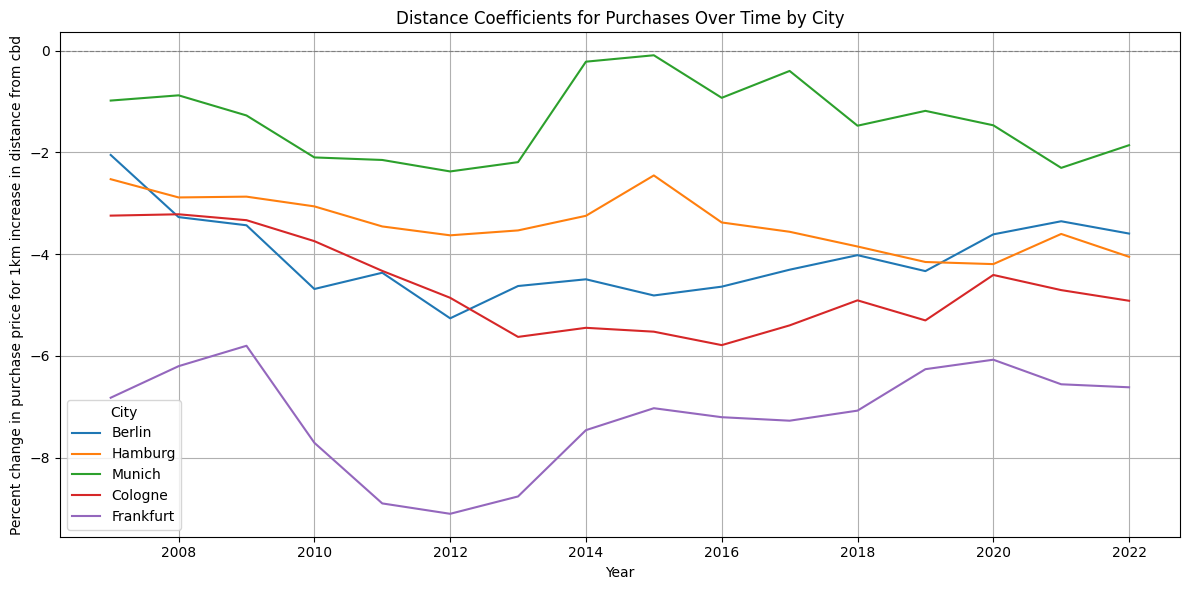

In [104]:
cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
years = range(2007, 2023) 
results_dict = {}

# Run regressions for each year and city
for year in years:
    year_col = f'lprice_qm{year}'
    results_dict[year] = {}
    for city in cities:
        df_city = gdf_purchase_index[gdf_purchase_index['city'] == city]
        if year_col in df_city.columns:
            df_city = df_city[[year_col, 'distance']].dropna()
            Y = df_city[year_col]
            X = sm.add_constant(df_city['distance'])
            model = sm.OLS(Y, X)
            results = model.fit()
            results_dict[year][city] = results

# Build DataFrame with coefficients
coef_df = pd.DataFrame(index=years, columns=[city.title() for city in cities])

for year in years:
    for city in cities:
        result = results_dict[year][city]
        # Rescale to 1km for ease of interpretaion and mulitply by 100 for percent interpretation
        coef_df.at[year, city.title()] = result.params['distance'] * 1000 * 100

# Plotting
plt.figure(figsize=(12, 6))

for city in coef_df.columns:
    plt.plot(coef_df.index, coef_df[city], label=city)

plt.title("Distance Coefficients for Purchases Over Time by City")
plt.xlabel("Year")
plt.ylabel("Percent change in purchase price for 1km increase in distance from cbd")
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(title="City")
plt.grid(True)
plt.tight_layout()
plt.show()


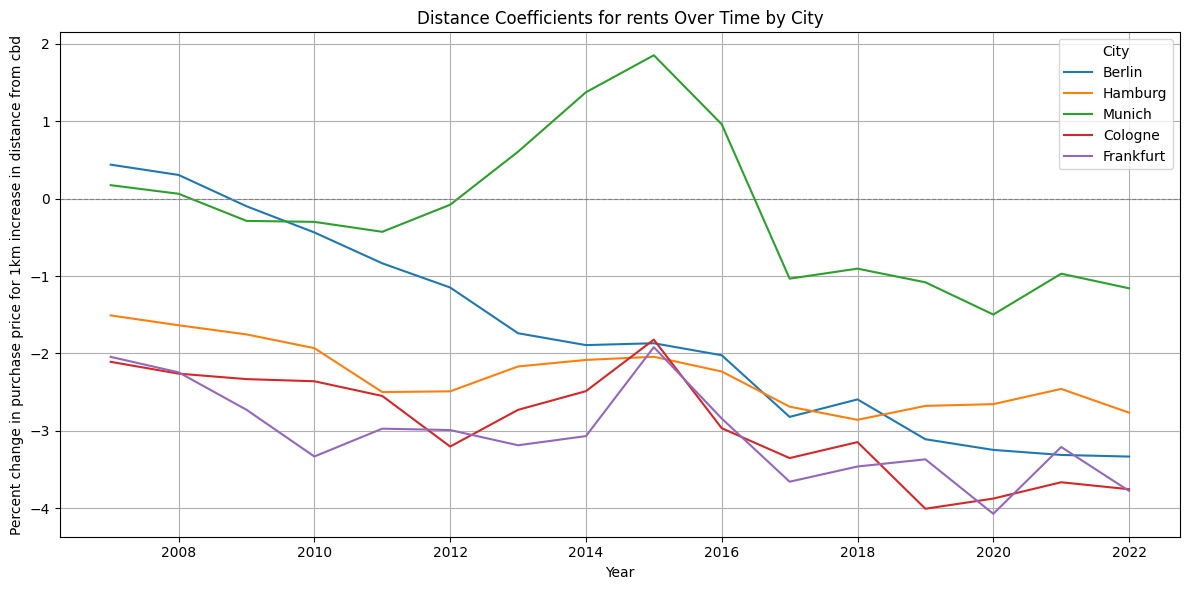

In [105]:
cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
years = range(2007, 2023) 
results_dict = {}

# Run regressions for each year and city
for year in years:
    year_col = f'lprice_qm{year}'
    results_dict[year] = {}
    for city in cities:
        df_city = gdf_rent_index[gdf_rent_index['city'] == city]
        if year_col in df_city.columns:
            df_city = df_city[[year_col, 'distance']].dropna()
            Y = df_city[year_col]
            X = sm.add_constant(df_city['distance'])
            model = sm.OLS(Y, X)
            results = model.fit()
            results_dict[year][city] = results

# Build DataFrame with coefficients
coef_df = pd.DataFrame(index=years, columns=[city.title() for city in cities])

for year in years:
    for city in cities:
        result = results_dict[year][city]
        # Rescale to 1km for ease of interpretaion and mulitply by 100 for percent interpretation
        coef_df.at[year, city.title()] = result.params['distance'] * 1000 * 100

# Plotting
plt.figure(figsize=(12, 6))

for city in coef_df.columns:
    plt.plot(coef_df.index, coef_df[city], label=city)

plt.title("Distance Coefficients for rents Over Time by City")
plt.xlabel("Year")
plt.ylabel("Percent change in purchase price for 1km increase in distance from cbd")
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(title="City")
plt.grid(True)
plt.tight_layout()
plt.show()


Munich seems very weird! Both for purchases but especially rents. Much clearer overall pattern visible for rents than for purchases (i.e. downwards pattern in line with monocentric city model hypothesis)

In [109]:
## Log-Level Model
import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'lprice_qm2007']
X = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          lprice_qm2007   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     24.95
Date:                Fri, 02 May 2025   Prob (F-statistic):           1.34e-06
Time:                        13:24:18   Log-Likelihood:                -8.8875
No. Observations:                 190   AIC:                             21.77
Df Residuals:                     188   BIC:                             28.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4134      0.040    186.549      0.0

In [110]:
## Log-Level Model
import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'dlprice_qm']
X = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             dlprice_qm   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     31.41
Date:                Fri, 02 May 2025   Prob (F-statistic):           7.36e-08
Time:                        13:24:21   Log-Likelihood:                 66.548
No. Observations:                 190   AIC:                            -129.1
Df Residuals:                     188   BIC:                            -122.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4651      0.027     54.837      0.0

In [111]:
## Log-Level Model
import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'percentage_change']
X = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      percentage_change   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     31.73
Date:                Fri, 02 May 2025   Prob (F-statistic):           6.39e-08
Time:                        13:24:24   Log-Likelihood:                -1075.9
No. Observations:                 190   AIC:                             2156.
Df Residuals:                     188   BIC:                             2162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        340.2058     10.917     31.163      0.0

In [112]:
condition = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 2500
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 5
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 2500) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 5000)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 4
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 5000) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 7500)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 3
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 7500) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 10000)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 2
condition = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 10000
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 1


In [115]:
## Log-Level Model

import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'dlprice_qm']
X = pd.get_dummies(gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance_dummy'], drop_first=True)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             dlprice_qm   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     11.35
Date:                Fri, 02 May 2025   Prob (F-statistic):           2.92e-08
Time:                        13:25:32   Log-Likelihood:                 72.726
No. Observations:                 190   AIC:                            -135.5
Df Residuals:                     185   BIC:                            -119.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2490      0.020     62.486      0.0

In [116]:
## Berlin CBD: 10117
## Munich CBD: 80331
# gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].sjoin(gpd.read_file('/Users/dominik.bursy/Downloads/shape_11/PL_11.shp').to_crs(gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].crs))

---

In [118]:
from shapely.geometry import Point

condition_cbd = (gdf_purchase_index['city'] == 'berlin') & (gdf_purchase_index['target_id'] == 10117)
df = pd.DataFrame({"Coordinates": [Point(gdf_purchase_index.loc[condition_cbd, 'target_x'], gdf_purchase_index.loc[condition_cbd, 'target_y'])]})

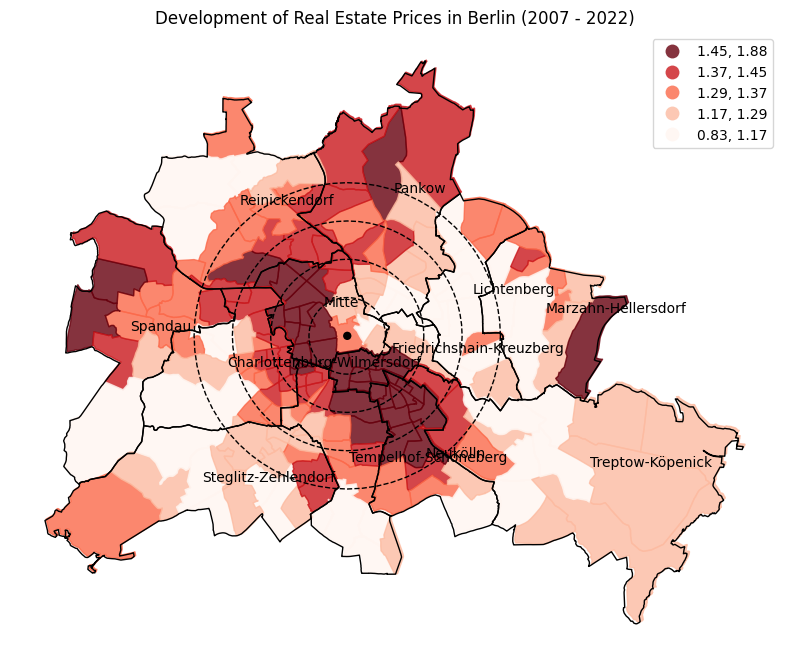

In [119]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).plot(facecolor='black', edgecolor='none', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(2500).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(5000).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(7500).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(10000).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## Task 4: Conclusion <a class="anchor" id="conclusion"></a>

- The model is a good proxy for how high rents and purchase prices tend to concentrate in city centers
- However, the price pattern in many cities is more complex than a single city center in the middle
- Assumption of one Commercial Business District (CBD) in city center often unrealistic in real world
    - High Real Estate prices in Berlin areas close to Potsdam cannot be explained by Monocentric city model
- City center confirms most to pattern observed in cities with a strong service sector (non-industry, e.g. Frankfurt) not requiring much space
    - But then, Home-Office fundamentally changes the pattern: people do not necessarily have to live close to the central workplace at all, workplaces in service sector will most likely decentralize in the future -> assumption of central city center becomes less and less credible
    - Cities with strong industry sector are not centralized to begin with

---

## Appendix <a class="anchor" id="appendix"></a>

In [124]:
## Normalize price index over the years

def normalize_min_max(df_column):
    return (df_column - df_column.min().min()) / (df_column.max().max() - df_column.min().min())

gdf_purchase_index.iloc[:,gdf_purchase_index.columns.str.startswith('price_qm')] = normalize_min_max(gdf_purchase_index.iloc[:,gdf_purchase_index.columns.str.startswith('price_qm')])

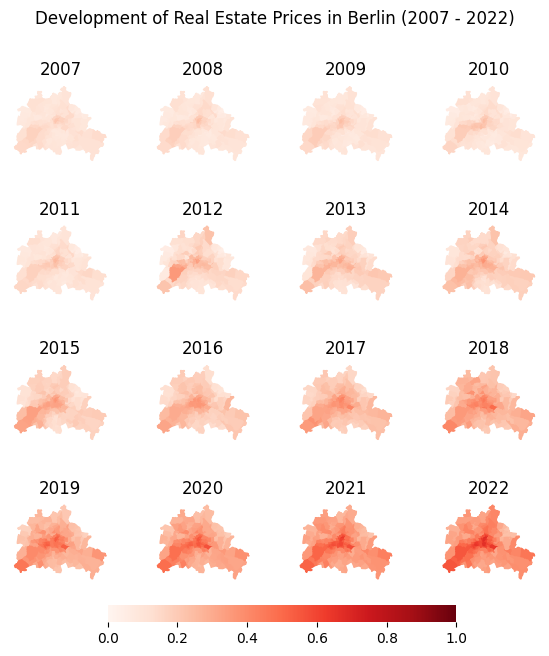

In [125]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

figure, axis = plt.subplots(4, 4, figsize=(6, 6)) 
axis = axis.flatten()

normalizer = Normalize(0, 1)
im = cm.ScalarMappable(norm=normalizer, cmap='Reds')

for index, year in enumerate(range(2007, 2023)):
    gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index], norm=normalizer)
    # axis[index].set_xticks([])
    # axis[index].set_yticks([])
    axis[index].set_axis_off()
    axis[index].set_title(f'{year}')
figure.suptitle('Development of Real Estate Prices in Berlin (2007 - 2022)')

cb = figure.colorbar(im, ax=axis.ravel().tolist(), location='bottom', orientation='horizontal', shrink=0.75, anchor=(0.5, -1.75))
cb.outline.set_visible(False)

figure.tight_layout()

## References <a class="anchor" id="references"></a>

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- [https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)
- ...

---